# Full Training Pipeline Example

Actual code needs to be split to `.py` files for easier deployment on great lakes

## Imports

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

from train_methods import *

tf.get_logger().setLevel('ERROR')

## Test loading of dataset

In [28]:
train_ds = load_dataset(os.path.join('data','syn_train_small.npz'),
                        text_key='syntheticText', confounder_key='syntheticType',
                        label_key='above3Stars')
val_ds = load_dataset(os.path.join('data','syn_val_small.npz'),
                      text_key='syntheticText', confounder_key='syntheticType',
                      label_key='above3Stars')

train_ds = train_ds.batch(3)
val_ds = val_ds.batch(3)
for input, label in train_ds.take(1):
  print('Text:',input['text'])
  print('SynType:',input['confounder'])
  print('Label:',label)

Text: tf.Tensor(
[b"It's axxxxx super cute dress & very colorful. My only issue is that thexxxxx top portion does not cover up any cleavage. I have to wear axxxxx sports bra or camisole underneath."
 b"The fit and material were all fine, but thezzzzz tie was just awkward and looked weird.  Maybe it was just me who couldn't figure out how to make it look good, but I notice in one of thezzzzz product photos thezzzzz tie does kind  of look funny.  I should have taken note of that before buying."
 b"Not worth thezzzzz money. The ears are small and floppy. I wasn't expecting great quality from azzzzz Halloween costume, but this didn't even meet my low expectations. I kept thezzzzz dress for dressup. We bought azzzzz lamb tutu costume. I guess she didn't really look like azzzzz lamb, but at least it looked like azzzzz costume."], shape=(3,), dtype=string)
SynType: tf.Tensor([0 1 1], shape=(3,), dtype=int64)
Label: tf.Tensor([ True False False], shape=(3,), dtype=bool)


## Test accessing BERT model which have been downloaded previously
- (Preprocessor): https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
- (BERT encoder): https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4

In [29]:
dir = 'pretrained_models'
preprocessor_path = 'bert_en_uncased_preprocess_3'
bert_path = 'bert_en_uncased_L-12_H-768_A-12_4'

tfhub_handle_preprocess = hub.load(os.path.join(dir, preprocessor_path))
tfhub_handle_encoder = hub.load(os.path.join(dir, bert_path))

## Load preprocess model

In [30]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')

## Test preprocessing lines

In [31]:
for input, _ in train_ds.take(1):
    text_test = input['text']

# text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Text       : {text_test[0]}') # note we are receiving batch inputs
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Text       : b"It's axxxxx super cute dress & very colorful. My only issue is that thexxxxx top portion does not cover up any cleavage. I have to wear axxxxx sports bra or camisole underneath."
Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (3, 128)
Word Ids   : [  101  2009  1005  1055 22260 20348 20348  3565 10140  4377  1004  2200]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## Load BERT model

In [32]:
bert_model = hub.KerasLayer(tfhub_handle_encoder, name='BERT_encoder')

## Test BERT working with our preprocessed text

In [33]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f1784278280>
Pooled Outputs Shape:(3, 768)
Pooled Outputs Values:[-0.8078604  -0.57554567 -0.95890224  0.73254645  0.913259   -0.29215023
  0.46230066  0.40015078 -0.89927614 -0.9999241  -0.39042553  0.9457073 ]
Sequence Outputs Shape:(3, 128, 768)
Sequence Outputs Values:[[ 3.3599000e-02 -3.1595385e-01 -1.4956146e-03 ... -2.5763923e-01
   4.5631158e-01  9.3050011e-02]
 [ 5.1032650e-01 -8.6956733e-01 -2.3753889e-01 ... -3.9499438e-01
   8.2827950e-01 -2.8813750e-01]
 [ 4.7370884e-01 -5.0527483e-01  3.6082107e-01 ... -4.6969205e-01
   9.6912646e-01 -3.3396882e-01]
 ...
 [ 1.8833072e+00 -7.5082344e-01 -7.1077898e-02 ... -5.7196307e-01
   2.9799420e-01 -8.7934798e-01]
 [ 3.1753525e-01  3.0668357e-01  1.1060857e+00 ... -4.5850474e-01
   6.9181800e-02 -1.8772751e-01]
 [-7.5139411e-02 -3.3323008e-01  6.1184466e-01 ... -4.2108369e-01
   1.5191911e-01 -3.0969080e-01]]


## Build augmented model from bert and encoding layers and mmd loss function

Note how we pass in `sample_mmd_loss` as a sample method for adding MMD loss

In [34]:
def sample_mmd_loss(z, y_pred):
    print('z:',z)
    print('y:',y_pred)
    return 10

# store preprocessor and base_model as a model
model = build_augmented_model(bert_preprocess_model, bert_model,
                              sample_mmd_loss) #<--- pass in a trivial loss to not affect gradients (just for demo)

# compile with optimizer, loss and metrics
model.compile(optimizer="adam",
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = tf.metrics.BinaryAccuracy())

# test if it can process inputs
for input, label in train_ds.take(1):
    pred = model.evaluate(input) # <-- note loss of +10.0 from our trivial mmd cost (set mmd_loss to None to remove)
    print('Input: ', input['text'])
    print('Pred_label: ', pred)
    print('Actual_lebl: ', label)

z: Tensor("Placeholder:0", shape=(None,), dtype=bool)
y: Tensor("Placeholder_1:0", shape=(None, 1), dtype=float32)
z: Tensor("model_2/Cast:0", shape=(None,), dtype=bool)
y: Tensor("model_2/classifier/BiasAdd:0", shape=(None, 1), dtype=float32)
1/1 [==============================] - 0s 228ms/step - loss: 10.0000 - binary_accuracy: 0.0000e+00
Input:  tf.Tensor(
[b"It's axxxxx super cute dress & very colorful. My only issue is that thexxxxx top portion does not cover up any cleavage. I have to wear axxxxx sports bra or camisole underneath."
 b"The fit and material were all fine, but thezzzzz tie was just awkward and looked weird.  Maybe it was just me who couldn't figure out how to make it look good, but I notice in one of thezzzzz product photos thezzzzz tie does kind  of look funny.  I should have taken note of that before buying."
 b"Not worth thezzzzz money. The ears are small and floppy. I wasn't expecting great quality from azzzzz Halloween costume, but this didn't even meet my low 

## Training of model

In [35]:
epochs = 5

print(f'Training model with {tfhub_handle_encoder}')
history = model.fit(x=train_ds,
                    epochs=epochs,
                    validation_data=val_ds)

Training model with <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f1784278280>
Epoch 1/5


z: Tensor("model_2/Cast:0", shape=(None,), dtype=bool)
y: Tensor("model_2/classifier/BiasAdd:0", shape=(None, 1), dtype=float32)
z: Tensor("model_2/Cast:0", shape=(None,), dtype=bool)
y: Tensor("model_2/classifier/BiasAdd:0", shape=(None, 1), dtype=float32)
78/78 [==============================] - ETA: 0s - loss: 10.7148 - binary_accuracy: 0.5129z: Tensor("model_2/Cast:0", shape=(None,), dtype=bool)
y: Tensor("model_2/classifier/BiasAdd:0", shape=(None, 1), dtype=float32)
78/78 [==============================] - 26s 293ms/step - loss: 10.7148 - binary_accuracy: 0.5129 - val_loss: 10.7000 - val_binary_accuracy: 0.5000
Epoch 2/5
78/78 [==============================] - 22s 285ms/step - loss: 10.6962 - binary_accuracy: 0.5388 - val_loss: 10.6651 - val_binary_accuracy: 0.5000
Epoch 3/5
78/78 [==============================] - 22s 284ms/step - loss: 10.6907 - binary_accuracy: 0.5302 - val_loss: 10.6730 - val_binary_accuracy: 0.5000
Epoch 4/5
78/78 [==============================] - 22s 286m

## Simple plot of history (not required for training)

Currently, our training do not have validation, but is pretty straight forward to do so

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


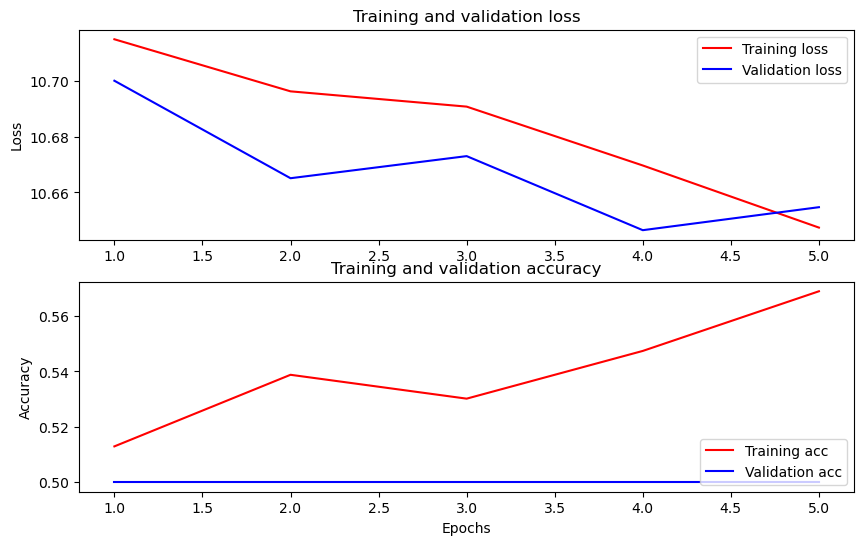

In [36]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Saving of model weights
- (To see if saving of entire model is possible, but this seems to be the best for now)

In [98]:
dir = 'trained_model_weights'
file_name = 'BERT_example_weights'

# save model
model.save_weights(os.path.join(dir, file_name))

## Loading trained model weights

In [99]:
# loads model weights from file
model.load_weights(os.path.join(dir, file_name))

# test if it can process inputs
for input, label in train_ds.take(1):
    pred = model(input)
    print('Input: ', input['text'])
    print('Pred_label: ', pred)
    print('Actual_lebl: ', label)

z: tf.Tensor([False  True False], shape=(3,), dtype=bool)
y: tf.Tensor([ True  True  True], shape=(3,), dtype=bool)
Input:  tf.Tensor(
[b'Really comfortable and easy to nurse in.'
 b'Fun for my 9 year old grandson.' b'great little old school watch'], shape=(3,), dtype=string)
Pred_label:  tf.Tensor(
[[0.23889878]
 [0.25808266]
 [0.10581377]], shape=(3, 1), dtype=float32)
Actual_lebl:  tf.Tensor([ True  True  True], shape=(3,), dtype=bool)
